In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os

# Read data

In [2]:
data = pd.read_csv("../data/search/search.csv")

In [3]:
data.head()

Время  Rambler, Визиты  Rambler, Доля  Mail.ru, Визиты  \
0  2015-01-01 - 2015-01-01           852160       0.007156          6795739   
1  2015-01-02 - 2015-01-02          1086015       0.007245          8437040   
2  2015-01-03 - 2015-01-03          1126459       0.007045          9017736   
3  2015-01-04 - 2015-01-04          1164893       0.007082          9215741   
4  2015-01-05 - 2015-01-05          1184689       0.007043          9448566   

   Mail.ru, Доля  Google, Визиты  Google, Доля  Яндекс, Визиты  Яндекс, Доля  \
0       0.057069        40889000      0.343375        67054003      0.563101   
1       0.056285        50295951      0.335533        85701308      0.571728   
2       0.056397        53498515      0.334583        91585678      0.572782   
3       0.056026        54686952      0.332465        94632940      0.575313   
4       0.056176        55658554      0.330913        97029139      0.576878   

   Остальные, Визиты  Остальные, Доля  
0            3488913         0.029299  
1            4378396         0.029209  
2            4667794         0.029193  
3            4789043         0.029115  
4            4876005         0.028990

In [4]:
data.columns

Index(['Время', 'Rambler, Визиты', 'Rambler, Доля', 'Mail.ru, Визиты',
       'Mail.ru, Доля', 'Google, Визиты', 'Google, Доля', 'Яндекс, Визиты',
       'Яндекс, Доля', 'Остальные, Визиты', 'Остальные, Доля'],
      dtype='object')

# Add columns

In [5]:
data['Дата'] = [adate[:10] for adate in data['Время'].values]
data['Год'] = [time.strptime(adate, "%Y-%m-%d").tm_year for adate in data['Дата'].values]
data['Месяц'] = [time.strptime(adate, "%Y-%m-%d").tm_mon for adate in data['Дата'].values]
data['Число'] = [time.strptime(adate, "%Y-%m-%d").tm_mday for adate in data['Дата'].values]
data['День недели'] = [time.strptime(adate, "%Y-%m-%d").tm_wday for adate in data['Дата'].values]
data['День года'] = [time.strptime(adate, "%Y-%m-%d").tm_yday for adate in data['Дата'].values]

In [6]:
data['Яндекс-Google, Визиты'] = data['Яндекс, Визиты'] - data['Google, Визиты']

# Select signal time series

In [7]:
y_column = 'Яндекс, Визиты'
x_column = 'Время'

# Data display

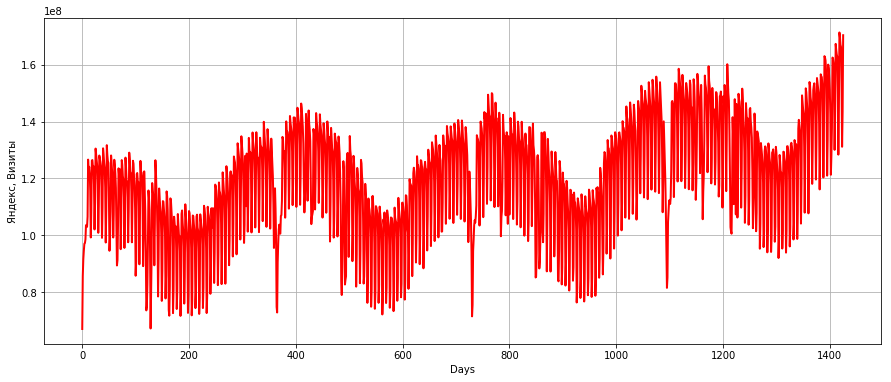

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(data[y_column].values, color='r', linewidth=2)
plt.ylabel(y_column)
plt.xlabel('Days')
plt.grid(b=1)
plt.show()

# Decomposition with weekly seasonality

In [9]:
y = data[y_column].values
week_day = data['День недели'].values

### Trend

In [10]:
y_trend = pd.rolling_mean(y, 7*1, center=False)

### Seasonality

In [11]:
y_detrend = y - y_trend

y_week_day = []
for i in range(7):
    y_week_day.append(np.nanmean(y_detrend[week_day == i]))
    
y_seasonal = np.array([y_week_day[i] for i in week_day])

### Remainder

In [12]:
y_remainder = y - y_trend - y_seasonal

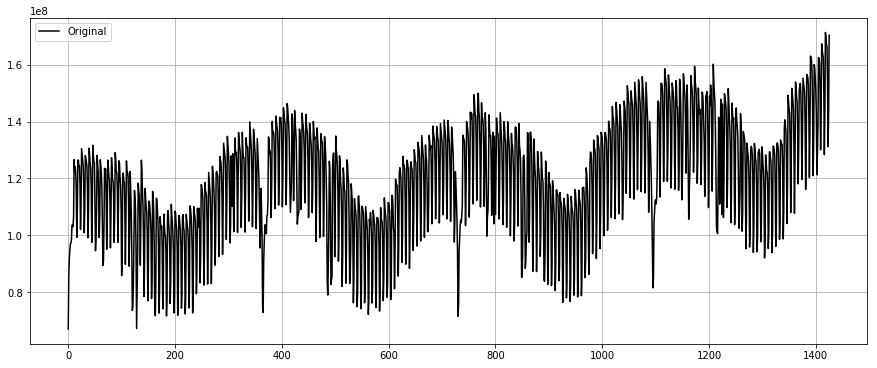

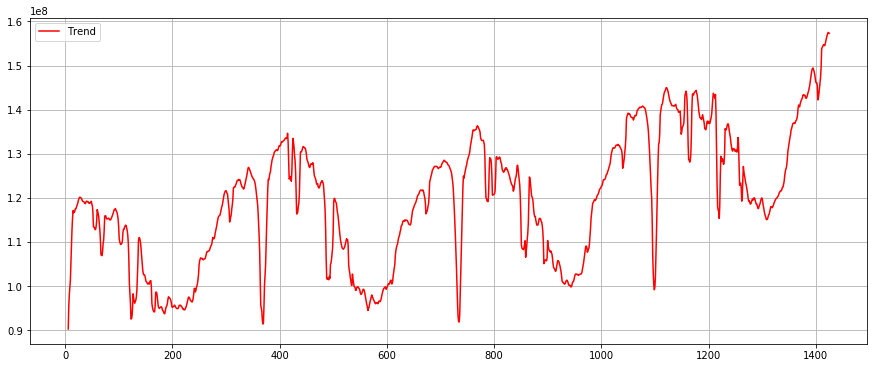

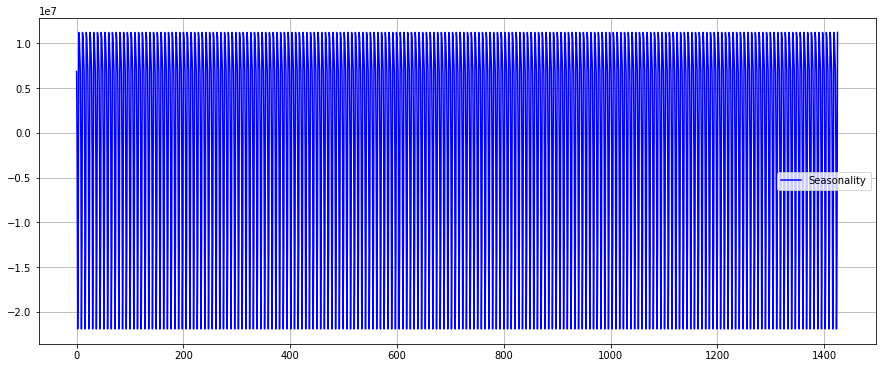

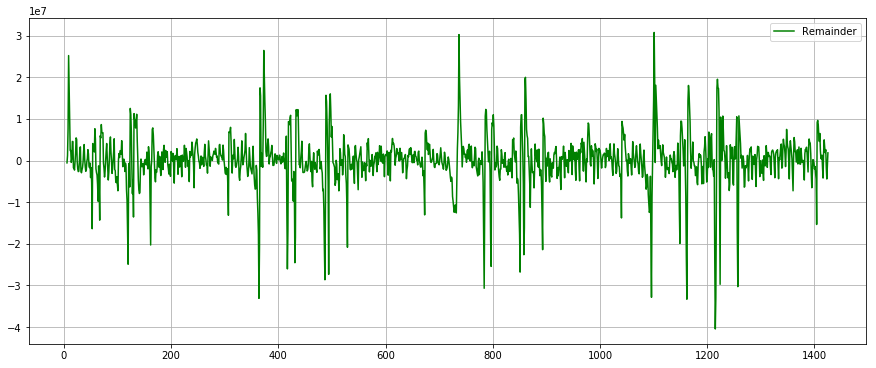

In [13]:
show_n = 10000

plt.figure(figsize=(15, 6))
plt.plot(y[:show_n], label='Original', color='0')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_trend[:show_n], label='Trend', color='r')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_seasonal[:show_n], label='Seasonality', color='b')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_remainder[:show_n], label='Remainder', color='g')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

# Задание #1

Сделайте разложение временного ряда с годовой сезонностью.

In [14]:
# Место для выполнения задания #1

# Forecast

### Create time slices for autoregression model

In [15]:
def time_slices(time_series, slice_size=10, forecast_horizont=1):
    
    n_slices = len(time_series)-slice_size-forecast_horizont
    
    X = []
    y = []
    
    for i_slice in range(n_slices):
        
        slice_x = time_series[i_slice:i_slice+slice_size]
        slice_y = time_series[i_slice+slice_size+forecast_horizont-1]
        
        X.append(slice_x)
        y.append(slice_y)
        
    return np.array(X), np.array(y)

In [16]:
SLICE_SIZE = 14
FORECAST_HORIZONT = 1


X, y = time_slices(data[y_column].values, slice_size=SLICE_SIZE, forecast_horizont=FORECAST_HORIZONT)
_, year = time_slices(data['Год'].values, slice_size=SLICE_SIZE, forecast_horizont=FORECAST_HORIZONT)
_, y_date = time_slices(data['Дата'].values, slice_size=SLICE_SIZE, forecast_horizont=FORECAST_HORIZONT)

In [17]:
X.shape, y.shape, year.shape

((1411, 14), (1411,), (1411,))

### Train/test split

In [18]:
thresh = 2018

X_train, y_train, y_date_train = X[year < thresh], y[year < thresh], y_date[year < thresh]
X_test, y_test, y_date_test = X[year >= thresh], y[year >= thresh], y_date[year >= thresh]

timestamps = np.arange(len(X))
timestamps_train = timestamps[year < thresh]
timestamps_test = timestamps[year >= thresh]

### Fit regression model

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# from xgboost import XGBRegressor

In [20]:
#reg = RandomForestRegressor()
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Make prediction

In [21]:
y_test_pred = reg.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
rel_error_test = (y_test_pred - y_test) / y_test
mean_rel_error_test = np.mean(rel_error_test)
print("RMSE: ", rmse_test)
print("Mean relative error: ", mean_rel_error_test)

RMSE:  7378708.7314828625
Mean relative error:  -0.005271668091395465


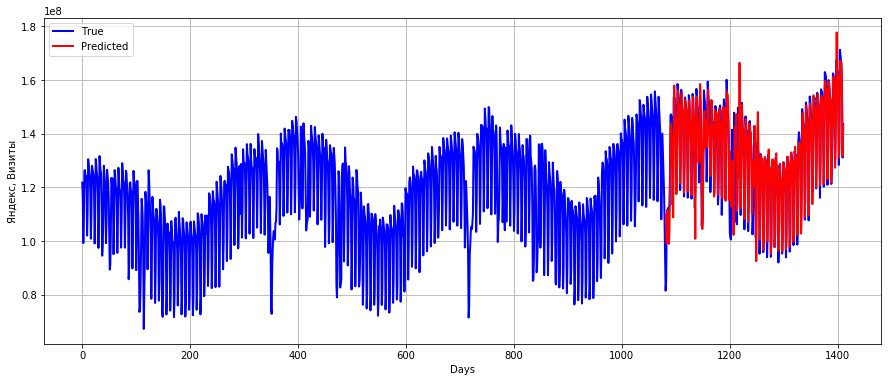

In [23]:
plt.figure(figsize=(15, 6))
plt.plot(timestamps, y, color='b', linewidth=2, label='True')
plt.plot(timestamps_test, y_test_pred, color='r', linewidth=2, label='Predicted')
plt.ylabel(y_column)
plt.xlabel('Days')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

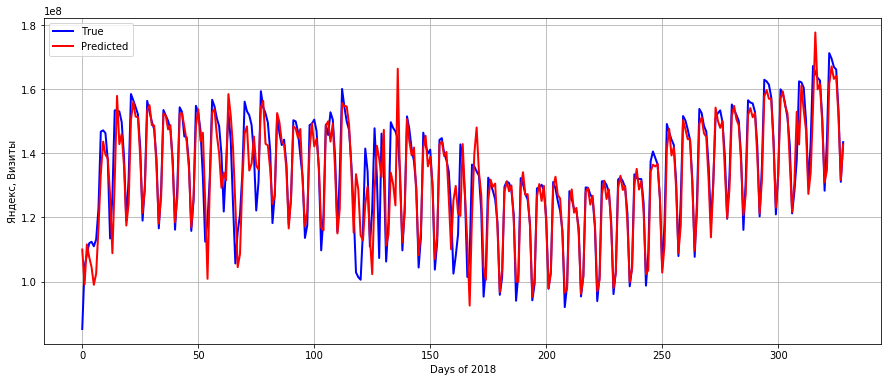

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(timestamps_test-timestamps_test[0], y_test, color='b', linewidth=2, label='True')
plt.plot(timestamps_test-timestamps_test[0], y_test_pred, color='r', linewidth=2, label='Predicted')
plt.ylabel(y_column)
plt.xlabel('Days of 2018')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

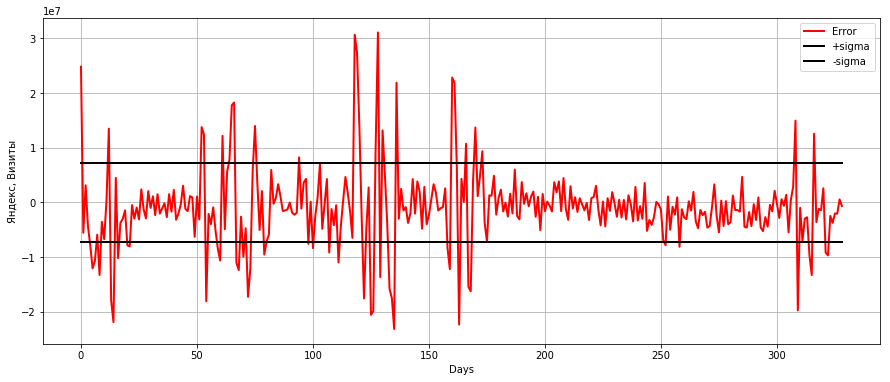

In [25]:
y_test_err = y_test_pred - y_test
sigma = np.std(y_test_err)

plt.figure(figsize=(15, 6))
plt.plot(timestamps_test-timestamps_test[0], y_test_err, color='r', linewidth=2, label='Error')
plt.plot(timestamps_test-timestamps_test[0], [sigma]*len(timestamps_test), color='0', linewidth=2, label='+sigma')
plt.plot(timestamps_test-timestamps_test[0], [-sigma]*len(timestamps_test), color='0', linewidth=2, label='-sigma')
plt.ylabel(y_column)
plt.xlabel('Days')
plt.legend(loc='best')
plt.grid(b=1)
plt.show()

# Задание #2

Получите наилучшую предсказательную модель.

# Anomalies detection

In [26]:
y_date_test[np.abs(y_test_err) > 2*sigma]

array(['2018-01-01', '2018-01-14', '2018-01-15', '2018-02-24',
       '2018-03-07', '2018-03-08', '2018-03-14', '2018-04-29',
       '2018-04-30', '2018-05-03', '2018-05-06', '2018-05-07',
       '2018-05-09', '2018-05-14', '2018-05-15', '2018-05-16',
       '2018-05-17', '2018-06-10', '2018-06-11', '2018-06-13',
       '2018-06-17', '2018-06-18', '2018-11-05', '2018-11-06'],
      dtype='<U10')

# Задание #3

Используйте предсказательную модель для детектирования аномалий во временном ряду. С чем связаны эти аномалии?